In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import math 
import sys
import os
from pathlib import Path as path

import pickle

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree 
from sklearn.tree import DecisionTreeClassifier

import sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [13]:
def read_and_clean(location,filename,target,drop_col):
    os.chdir(location)

    df = pd.read_csv(filename,engine = 'python')
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0',axis = 1).set_index('date')
    else:
        df = df.set_index('date')
    if target == None:
        target = 'time_to_sell'
        df['time_to_sell'] = np.where(df['percent_change_avg'] < 0, False,True)
        print(df.groupby('time_to_sell').count()['percent_change_avg'])
        y = np.array(df['time_to_sell'])
    else:
        y = np.invert(np.array(df[target]))

    X = df.drop(drop_col,axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=seed)

    return [X, X_train, X_test], [y, y_train, y_test], df  

In [14]:
seed = 54
np.random.seed(seed)

loc = (os.getcwd())
filename = 'minute_df_18Aug.csv'
target = ''
df = pd.read_csv(filename,engine = 'python')
for x in df:
    if (pd.api.types.is_bool_dtype(df[x])):
        if target == '':
            target = x
        else:
            target = None
            """print(f'Another potential target found, drop column {x} or {target} from the dataframe')
            print(f'Press 1 to drop {target}\nPress 2 to drop {x}')
            inp = input("Enter Choice:")
            while inp != 'done':
                

                if (inp == '1'):
                    df.drop(target,axis = 1)
                    inp = 'done'
                if (inp == '2'):
                    df.drop(x,axis = 1)
                    inp = 'done'
                else:
                    inp = input()"""

drop_col = ['percent_change_avg','open_avg','close_avg','low_avg','high_avg','up_down']


In [15]:
def get_performance_scores(y_test, y_predict, y_predict_prob, eps=1e-15, beta=0.5):
    from sklearn import metrics
    # Scores keys.
    metric_keys = ["accuracy", "precision", "recall", "f1", "fbeta", "log_loss", "AUC"]
    # Score values.
    metric_values = [None]*len(metric_keys)
    metric_values[0] = metrics.accuracy_score(y_test, y_predict)
    metric_values[1] = metrics.precision_score(y_test, y_predict)
    metric_values[2] = metrics.recall_score(y_test, y_predict)
    metric_values[3] = metrics.f1_score(y_test, y_predict)
    metric_values[4] = metrics.fbeta_score(y_test, y_predict, beta=beta)
    metric_values[5] = metrics.log_loss(y_test, y_predict_prob[:, 1], eps=eps)
    metric_values[6] = metrics.roc_auc_score(y_test, y_predict_prob[:, 1])
    perf_metrics = dict(zip(metric_keys, metric_values))
    return(perf_metrics)
    

def confusion_matrix_maker(y_test,predicted_y_test):
    cm = confusion_matrix(y_test, predicted_y_test)
    print(cm)
    print(round(accuracy_score(y_test, predicted_y_test), 4))
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Wistia)
    classNames = ['Buy', 'Sell']
    plt.title('Confusion Matrix - Test Data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation = 45)
    plt.yticks(tick_marks, classNames)
    s = [['True Buy', 'False Sell'], ['False Buy', 'True Sell']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j]) + " = " + str(cm[i][j]))
    plt.show()
    plt.close()
    return cm


def feature_importance_plot(X,estimator,ensemble):
    features = X[0].columns
    importances = estimator.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_indices = indices[0:10][::-1]
    plt.figure(1)
    plt.title('Feature Importance of Bitcoin Transactions and Tweet Data using ' + ensemble.upper() + ' Technique')
    plt.barh(range(len(top_indices)), importances[top_indices], color = 'b', align = 'center')
    labels = features[top_indices]
    plt.yticks(range(len(top_indices)), labels)
    plt.xlabel('Relative Importance')
    plt.show()
    plt.close()


def run_ensemble(X,Y,ensemble,seed):
    if 'rf' in ensemble:
        estimator = RandomForestClassifier(n_estimators = 250,
        random_state = seed)

    if 'gbm' in ensemble:
        estimator = GradientBoostingClassifier(n_estimators = 100,
        random_state = seed)
    
    estimator.fit(X[1],Y[1])
    y_pred = estimator.predict(X[2])
    y_pred_probability = estimator.predict_proba(X[2]) 
    
    if 'opt' not in ensemble:
        cm = confusion_matrix_maker(Y[2],y_pred)
        accuracy_measure = metrics.accuracy_score(Y[2], y_pred)
        print(f"Accuracy for {ensemble.upper()} on test data: ", accuracy_measure)
        accuracy_train = estimator.score(X[1],Y[1])
        print ("Train Accuracy:", accuracy_train)

        feature_importance_plot(X,estimator,ensemble)
        perf_dict = get_performance_scores(Y[2], y_pred, y_pred_probability)
        
        return estimator, cm, perf_dict
    else:
        return estimator


In [16]:
X, Y, df = read_and_clean(loc,filename,target,drop_col)

for y in Y:

    unique, counts = np.unique(y, return_counts=True)
    print('Y:', unique, counts)

Y: [False  True] [12887 12663]
Y: [False  True] [8993 8892]
Y: [False  True] [3894 3771]


[[2006 1888]
 [1903 1868]]
0.5054


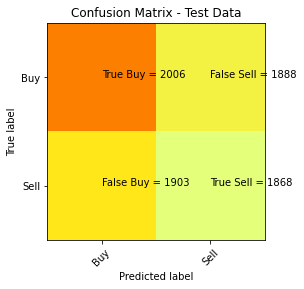

Accuracy for RF on test data:  0.5054142204827137
Train Accuracy: 1.0


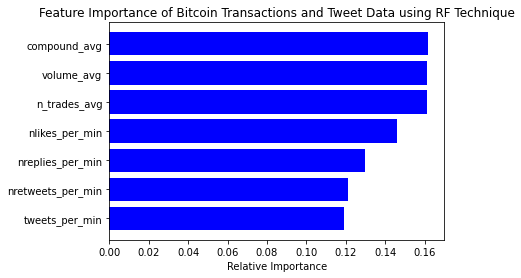

In [17]:
estimator_rf,cm_rf, perf_rf = run_ensemble(X,Y,'rf',seed)

[[2445 1449]
 [2226 1545]]
0.5205


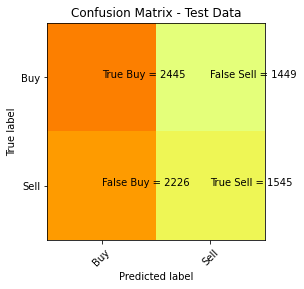

Accuracy for GBM on test data:  0.5205479452054794
Train Accuracy: 0.5831143416270618


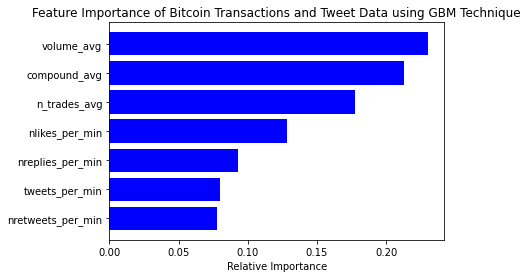

In [18]:
estimator_gbm,cm_gbm, perf_gbm = run_ensemble(X,Y,'gbm',seed)


In [19]:
def optimized_ensemble(X,Y,ensemble,seed):
    estimator = run_ensemble(X,Y,ensemble,seed)
    estimator.get_params
    # Number of trees in random forest.
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 20)]
    # Number of features to consider at every split.
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree.
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node.
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node.
    min_samples_leaf = [1, 2, 4]
    if ensemble == 'rf_opt':
        # best parameters found using randomized grid search: 
        # {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 70}

        # randomized grid search param_distributions were:
        #grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth, 'min_samples_split': min_samples_split,'min_samples_leaf': min_samples_leaf}        
        n_estimators = [389]
        min_samples_split = [5]
        min_samples_leaf = [4]
        max_features = ['sqrt']
        max_depth = [70]
        
        grid = {'n_estimators': n_estimators,
                    'max_features': max_features,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf}
    if ensemble == 'gbm_opt':
        learning_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
        # best parameters found using randomized grid search: 
        # {'n_estimators': 389, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'learning_rate': 0.3}

        # randomized grid search param_distributions were:
        # grid = {'n_estimators': n_estimators,'max_features': max_features,'max_depth': max_depth,'min_samples_split': min_samples_split,'min_samples_leaf': min_samples_leaf,'learning_rate': learning_rate}  
        n_estimators = [389]
        min_samples_split = [2]
        min_samples_leaf = [1]
        max_features = ['auto']
        max_depth = [10]
        learning_rate = [0.3]
        # Create the random grid.
        grid = {'n_estimators': n_estimators,
                        'max_features': max_features,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf,
                        'learning_rate': learning_rate}  
    search = RandomizedSearchCV(estimator = estimator, 
                                  param_distributions = grid, 
                                  n_iter = 100, 
                                  cv = 10, 
                                  verbose=3, 
                                  random_state= seed, 
                                  n_jobs = -1)
    # Fit the random search model.
    search.fit(X[1], Y[1])
    print(search.best_params_)
    if ensemble == 'rf_opt':
        optimized_ensemble_model = RandomForestClassifier(**search.best_params_)
    if ensemble == 'gbm_opt':
        optimized_ensemble_model = GradientBoostingClassifier(**search.best_params_)

    optimized_ensemble_model.fit(X[1], Y[1])


    y_pred = optimized_ensemble_model.predict(X[2])
    y_pred_probability = optimized_ensemble_model.predict_proba(X[2])

    cm = confusion_matrix_maker(Y[2],y_pred)
    accuracy_measure = metrics.accuracy_score(Y[2], y_pred)
    print(f"Accuracy for {ensemble.upper()} on test data: ", accuracy_measure)
    accuracy_train = estimator.score(X[1],Y[1])
    print ("Train Accuracy:", accuracy_train)

    feature_importance_plot(X,estimator,ensemble)
    perf_dict = get_performance_scores(Y[2], y_pred, y_pred_probability)
    
    return estimator, cm, perf_dict
         

Fitting 10 folds for each of 1 candidates, totalling 10 fits


/Users/daven/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV 6/10] END max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=389;, score=0.508 total time=  22.7s
[CV 3/10] END max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=389;, score=0.511 total time=  23.0s
[CV 2/10] END max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=389;, score=0.514 total time=  23.1s
[CV 4/10] END max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=389;, score=0.473 total time=  23.2s
[CV 5/10] END max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=389;, score=0.501 total time=  23.5s
[CV 1/10] END max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=389;, score=0.491 total time=  23.7s
[CV 7/10] END max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=389;, score=0.512 total time=  23.8s
[CV 8/10] END max_depth=70, max_fe

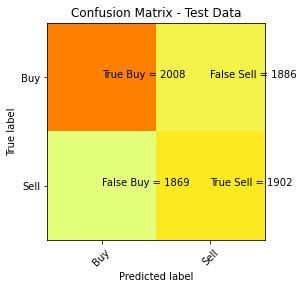

Accuracy for RF_OPT on test data:  0.5101108936725375
Train Accuracy: 1.0


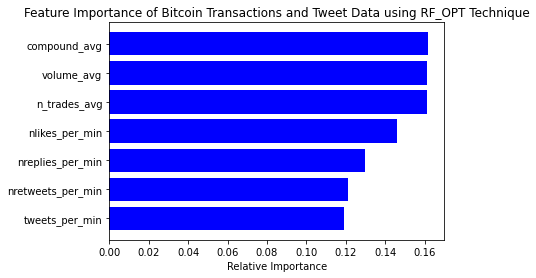

In [20]:
estimator_rf_opt, cm_rf_opt, perf_rf_opt = optimized_ensemble(X,Y,'rf_opt',seed)

# best parameters were found to be:
# {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 70}


/Users/daven/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 6/10] END learning_rate=0.3, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=389;, score=0.493 total time=  54.8s
[CV 2/10] END learning_rate=0.3, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=389;, score=0.540 total time=  55.0s
[CV 4/10] END learning_rate=0.3, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=389;, score=0.502 total time=  55.0s
[CV 5/10] END learning_rate=0.3, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=389;, score=0.514 total time=  55.1s
[CV 1/10] END learning_rate=0.3, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=389;, score=0.538 total time=  55.2s
[CV 7/10] END learning_rate=0.3, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=389;, score=0.518 total time=  55.

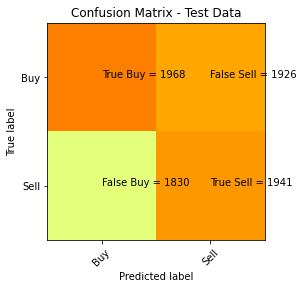

Accuracy for GBM_OPT on test data:  0.5099804305283757
Train Accuracy: 0.5831143416270618


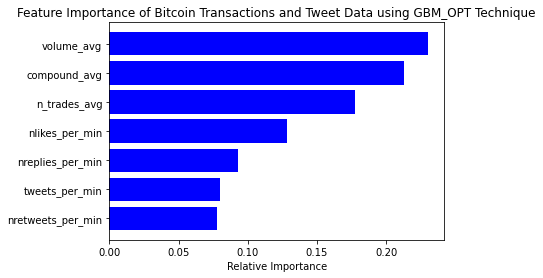

In [21]:
estimator_gbm_opt, cm_gbm_opt, perf_gbm_opt = optimized_ensemble(X,Y,'gbm_opt',seed)
# best parameters were found to be: 
# {'n_estimators': 389, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 10, 'learning_rate': 0.3}


/Users/daven/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:292: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 6/10] END learning_rate=0.3, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=389;, score=0.493 total time=  49.9s
[CV 2/10] END learning_rate=0.3, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=389;, score=0.540 total time=  50.1s
[CV 4/10] END learning_rate=0.3, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=389;, score=0.502 total time=  50.3s
[CV 5/10] END learning_rate=0.3, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=389;, score=0.514 total time=  50.3s
[CV 3/10] END learning_rate=0.3, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=389;, score=0.541 total time=  50.4s
[CV 1/10] END learning_rate=0.3, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=389;, score=0.538 total time=  50.

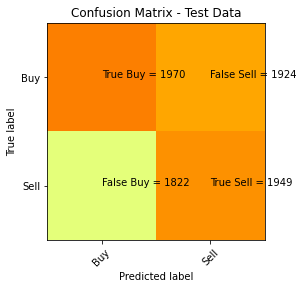

Accuracy for GBM_OPT on test data:  0.5112850619699935
Train Accuracy: 0.5831143416270618


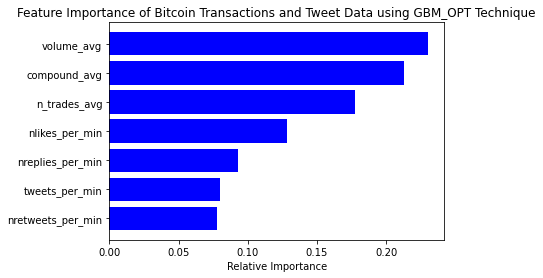

In [22]:
estimator_gbm_opt, cm_gbm_opt, perf_gbm_opt = optimized_ensemble(X,Y,'gbm_opt',seed)


In [27]:
metrics_dict = {'rf':perf_rf}
metrics_dict.update({'rf_optimized':perf_rf_opt})
metrics_dict.update({'gbm':perf_gbm})
metrics_dict.update({'gbm_optimized':perf_gbm_opt})

In [41]:
metrics_df = pd.DataFrame.from_dict(metrics_dict)
metrics_df_t = metrics_df.transpose()

In [42]:
metrics_df_t

,accuracy,precision,recall,f1,fbeta,log_loss,AUC
rf,0.505414,0.497338,0.495359,0.496346,0.496941,0.703070,0.512130
rf_optimized,0.510111,0.502112,0.504375,0.503241,0.502563,0.699092,0.514447
gbm,0.520548,0.516032,0.409706,0.456763,0.490570,0.693787,0.515628
gbm_optimized,0.511285,0.503227,0.516839,0.509942,0.505892,1.009360,0.515739


In [25]:
metrics_dict['rf'] = perf_rf

In [4]:
perf_rf_original= {'accuracy': 0.5054142204827137,
 'precision': 0.49733759318423854,
 'recall': 0.49535932113497744,
 'f1': 0.49634648598379166,
 'fbeta': 0.4969406757116254,
 'log_loss': 0.7030696835585883,
 'AUC': 0.5121301877096545}

{'accuracy': 0.5054142204827137,
 'precision': 0.49733759318423854,
 'recall': 0.49535932113497744,
 'f1': 0.49634648598379166,
 'fbeta': 0.4969406757116254,
 'log_loss': 0.7030696835585883,
 'AUC': 0.5121301877096545}

In [6]:
perf_gbm_original={'accuracy': 0.5205479452054794,
 'precision': 0.5160320641282565,
 'recall': 0.40970564836913287,
 'f1': 0.45676274944567635,
 'fbeta': 0.4905696323109165,
 'log_loss': 0.6937870440075267,
 'AUC': 0.5156283177499957}

{'accuracy': 0.5205479452054794,
 'precision': 0.5160320641282565,
 'recall': 0.40970564836913287,
 'f1': 0.45676274944567635,
 'fbeta': 0.4905696323109165,
 'log_loss': 0.6937870440075267,
 'AUC': 0.5156283177499957}

In [8]:
perf_rf_opt_original={'accuracy': 0.510371819960861,
 'precision': 0.5023860021208908,
 'recall': 0.5025192256695836,
 'f1': 0.502452605064298,
 'fbeta': 0.5024126411792779,
 'log_loss': 0.6992805890380838,
 'AUC': 0.5158415731005837}

{'accuracy': 0.510371819960861,
 'precision': 0.5023860021208908,
 'recall': 0.5025192256695836,
 'f1': 0.502452605064298,
 'fbeta': 0.5024126411792779,
 'log_loss': 0.6992805890380838,
 'AUC': 0.5158415731005837}

In [10]:
perf_gbm_opt_original={'accuracy': 0.5170254403131116,
 'precision': 0.5091197462331483,
 'recall': 0.5107398568019093,
 'f1': 0.5099285146942016,
 'fbeta': 0.5094429455641961,
 'log_loss': 0.9945892991525492,
 'AUC': 0.5267039419177277}

{'accuracy': 0.5170254403131116,
 'precision': 0.5091197462331483,
 'recall': 0.5107398568019093,
 'f1': 0.5099285146942016,
 'fbeta': 0.5094429455641961,
 'log_loss': 0.9945892991525492,
 'AUC': 0.5267039419177277}

/Users/daven/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/daven/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


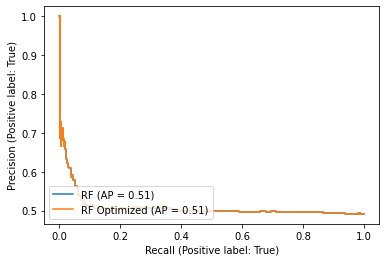

/Users/daven/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/daven/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


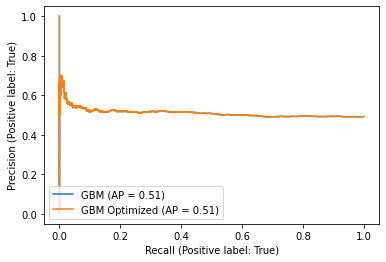

In [32]:
# NOTE: explain why plt.gca is
ax = plt.gca()

rf_prec_recall = metrics.plot_precision_recall_curve(estimator_rf, 
                                                            X[2], 
                                                            Y[2], ax = ax, 
                                                            name = "RF")
rf_opt_prec_recall = metrics.plot_precision_recall_curve(estimator_rf_opt, 
                                                            X[2], 
                                                            Y[2], ax = ax,
                                                            name = "RF Optimized")
plt.show()
plt.close()

ax2 = plt.gca()

gbm_prec_recall = metrics.plot_precision_recall_curve(estimator_gbm, 
                                                            X[2], 
                                                            Y[2], ax = ax2, 
                                                            name = "GBM")
gbm_opt_prec_recall = metrics.plot_precision_recall_curve(estimator_gbm_opt, 
                                                            X[2], 
                                                            Y[2], ax = ax2,
                                                            name = "GBM Optimized")
plt.show()
plt.close()


/Users/daven/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/daven/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


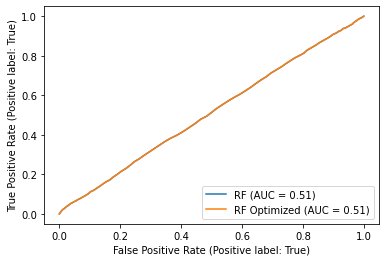

/Users/daven/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/daven/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


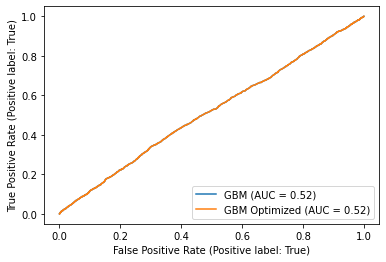

In [115]:
ax = plt.gca()


# NOTE: explain why plt.gca is
ax = plt.gca()

rf_prec_recall = metrics.plot_roc_curve(estimator_rf, 
                                                            X[2], 
                                                            Y[2], ax = ax, 
                                                            name = "RF")
rf_opt_prec_recall = metrics.plot_roc_curve(estimator_rf_opt, 
                                                            X[2], 
                                                            Y[2], ax = ax,
                                                            name = "RF Optimized")
plt.show()
plt.close()

# NOTE: explain why plt.gca is
ax2 = plt.gca()

gbm_prec_recall = metrics.plot_roc_curve(estimator_gbm, 
                                                            X[2], 
                                                            Y[2], ax = ax2, 
                                                            name = "GBM")
gbm_opt_prec_recall = metrics.plot_roc_curve(estimator_gbm_opt, 
                                                            X[2], 
                                                            Y[2], ax = ax2,
                                                            name = "GBM Optimized")
plt.show()
plt.close()

In [43]:
metrics_df_t

,accuracy,precision,recall,f1,fbeta,log_loss,AUC
rf,0.505414,0.497338,0.495359,0.496346,0.496941,0.703070,0.512130
rf_optimized,0.510111,0.502112,0.504375,0.503241,0.502563,0.699092,0.514447
gbm,0.520548,0.516032,0.409706,0.456763,0.490570,0.693787,0.515628
gbm_optimized,0.511285,0.503227,0.516839,0.509942,0.505892,1.009360,0.515739


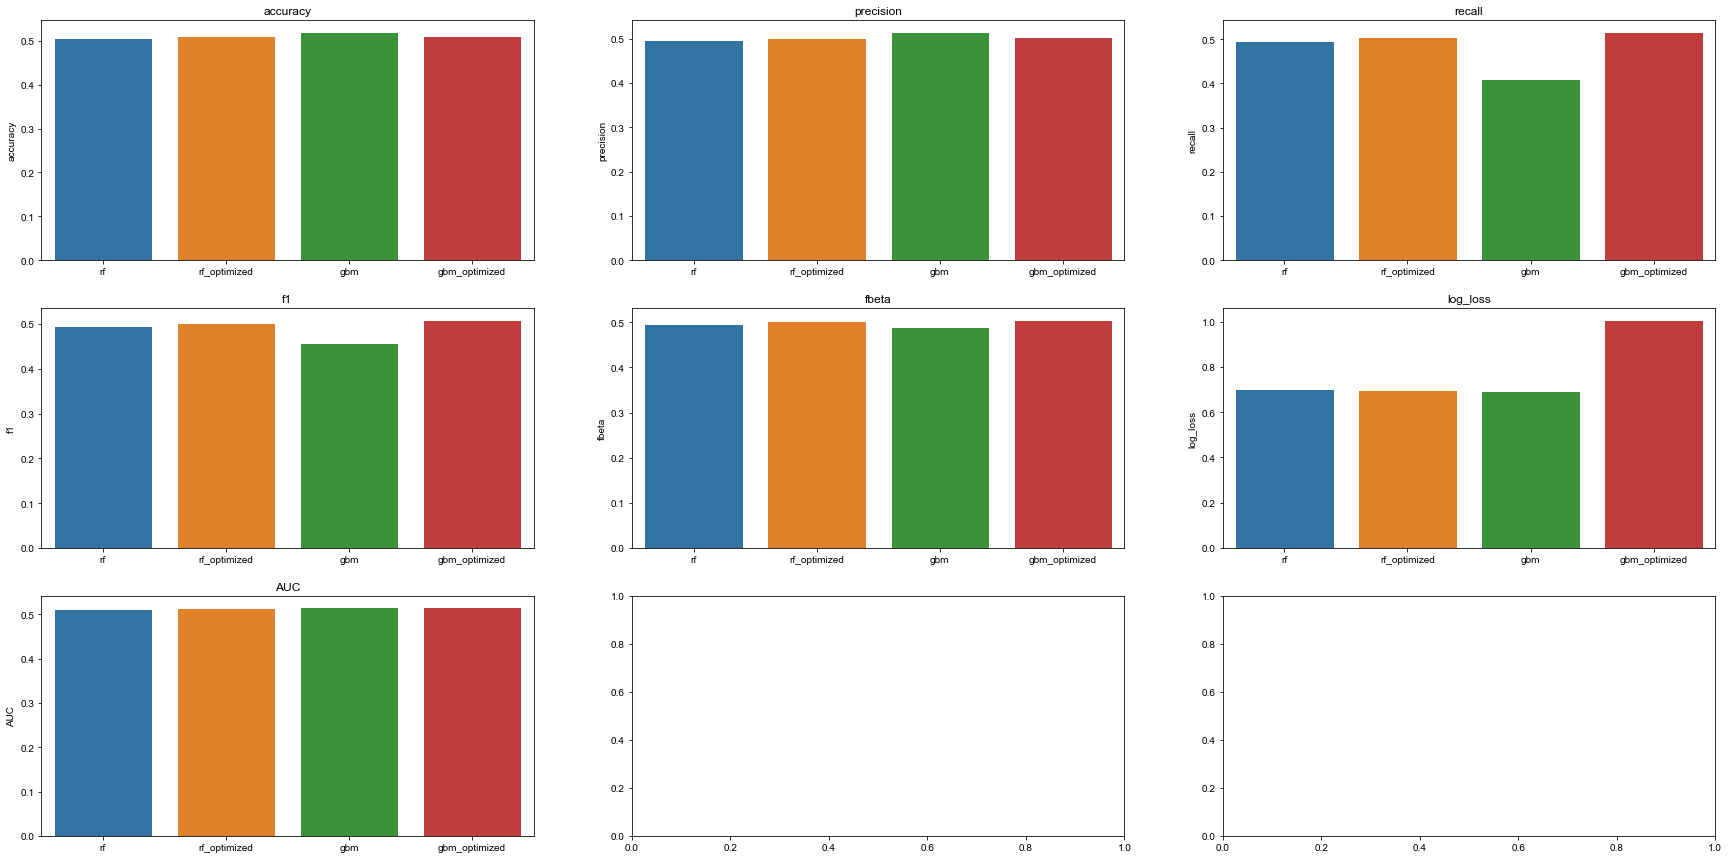

In [66]:
fig, axes = plt.subplots(3, 3, figsize = (30, 15))
row  = 0
column = 0
sns.set_style("dark")

for col in metrics_df_t:
    plot = sns.barplot(data = metrics_df_t,x = metrics_df_t.index, y = col, ax = axes[row, column])

    plot.set(title = col)
    column += 1
    if column == 3:
        row += 1
        column = 0

plt.show()
plt.close()

method